In [1]:
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from os.path import exists

import seaborn as sns

In [2]:
def read_result(read, method, folder_path, I, grad, nc=300):
    
    tls, tas, vls, vas, test_accs =  [], [], [], [], []
    
    for ith in read:
        tls.append(np.load(folder_path + method + grad + "I" + str(I) + "/tl_" + str(ith)+".npy"))
        tas.append(np.load(folder_path + method + grad + "I" + str(I) + "/ta_" + str(ith)+".npy"))
        vls.append(np.load(folder_path + method + grad + "I" + str(I) + "/vl_" + str(ith)+".npy"))
        vas.append(np.load(folder_path + method + grad + "I" + str(I) + "/va_" + str(ith)+".npy"))
        test_accs.append(torch.load(folder_path + method + grad + "I" + str(I) + "/model_" + str(ith), 
                                    map_location=torch.device('cpu'))["test_acc"])
    ts = I*len(tls[0])
    steps = np.arange(I, ts+I, I)
    
    try:
        return np.array(tls), np.array(tas), np.array(vls), np.array(vas), np.array(test_accs), steps
    except:
        test_accs = [test_acc.cpu() for test_acc in test_accs]
        return np.array(tls), np.array(tas), np.array(vls), np.array(vas), np.array(test_accs), steps

In [40]:
folder =  "experiments/cora/result/"
method = "GFLAPPNP/"
mcora = ["10 biased_grad/", "20 biased_grad/", "10 hg_noise_1_1/", "10 h_noise_1/", "10 h_noise_0.1/", "10 hg_noise_0.1_0.1/",
         "20 hg_noise_1_1/", "20 hg_noise_0.1_0.1/", "20 h_noise_1/", "20 h_noise_0.1/"]
exps = np.arange(20)
exp_name = "subCora_DNC"

testacc_means = []
vnames = []
enames = []
testacc_stds = []


for m in mcora:

    I, grad = m.split(" ")
    I = int(I)

    grad_name = grad

    tls, tas, vls, vas, test_accs, steps = read_result(exps, method, folder, I, grad)
    testacc_means.append(np.mean(test_accs))
    testacc_stds.append(1.96*np.std(test_accs)/np.sqrt(20))
    vnames.append(grad_name+"I="+str(I))
    enames.append(exp_name)

        
dp_subcora = pd.DataFrame(zip(enames, vnames, testacc_means, testacc_stds))
dp_subcora = dp_subcora.sort_values(2)
dp_subcora

,0,1,2,3
2,subCora_DNC,hg_noise_1_1/I=10,0.511268,0.037497
6,subCora_DNC,hg_noise_1_1/I=20,0.520190,0.039781
8,subCora_DNC,h_noise_1/I=20,0.536522,0.041268
3,subCora_DNC,h_noise_1/I=10,0.537956,0.041524
0,subCora_DNC,biased_grad/I=10,0.540672,0.037175
1,subCora_DNC,biased_grad/I=20,0.542690,0.037327
9,subCora_DNC,h_noise_0.1/I=20,0.544665,0.039973
4,subCora_DNC,h_noise_0.1/I=10,0.546903,0.040015
5,subCora_DNC,hg_noise_0.1_0.1/I=10,0.547148,0.039212
7,subCora_DNC,hg_noise_0.1_0.1/I=20,0.547460,0.039435


DNC SubCora:

I=10:
hg_1_1, hg_0.1_0.1, h_1, h_0.1


I=20:
hg_1_1, hg_0.1_0.1, h_1, h_0.1




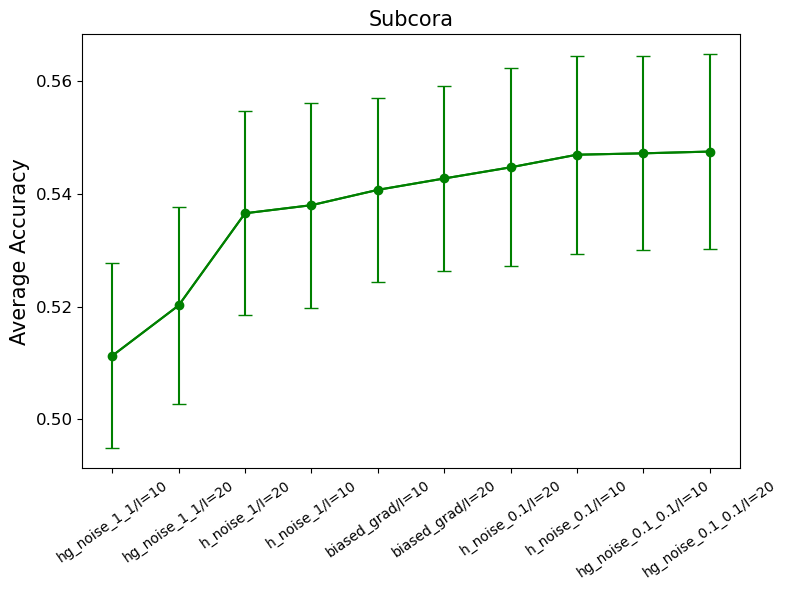

In [42]:
df = dp_subcora
x = np.arange(dp_subcora.shape[0])
y = df.iloc[:,2]
yerr = 1.96*df.iloc[:,3 ]/np.sqrt(20)

plt.figure(figsize=(8, 6))
plt.errorbar(x, y, yerr, marker="o", markersize=6, capsize=5, color="green")
plt.plot(x, y, color="green")
plt.xticks(np.arange(dp_subcora.shape[0]), df.iloc[:,1], fontsize=10, rotation=35)
plt.yticks(fontsize=12)
#plt.xlabel(r"$\lambda_{\max} (B_N L^{\dagger})$", fontsize=18)
plt.ylabel("Average Accuracy", fontsize=15)
plt.title("Subcora", fontsize=15)
plt.tight_layout()
#plt.savefig("experiments/connectivity.jpeg")

In [13]:
plt.rcParams['xtick.labelsize'] = 30

plt.rcParams['ytick.labelsize'] = 30

fig, ax = plt.subplots(1, 2, figsize=(40, 20), dpi=400)

folder = "experiments/cora/result/"
method = "GFLAPPNP/"
mcora = ["20 hg_noise_1_1/", "20 hg_noise_0.1_0.1/", "20 h_noise_1/", "20 h_noise_0.1/"]
exps = np.arange(20)
exp_name = "subCora_DNC"
color_map = {
             "20 biased_grad/": "blue",
             "20 h_noise_1/":"pink",
             "20 h_noise_0.1/": "red",
             "20 hg_noise_1_1/": "green",
             "20 hg_noise_0.1_0.1/": "purple"}

testacc_means = []
names = []
testacc_stds = []


    
for m in mcora:

    I, grad = m.split(" ")
    I = int(I)
    grad_name = grad

    tls, tas, vls, vas, test_accs, steps = read_result(exps, method, folder, I, grad)
    testacc_means.append(np.mean(test_accs))
    testacc_stds.append(np.std(test_accs))
    names.append(exp_name+grad_name+str(I))
    tls_mean, tls_std = np.mean(tls,axis=0), np.std(tls,axis=0)
    vls_mean, vls_std = np.mean(vls,axis=0), np.std(vls,axis=0)

    c = color_map[m]

    ax[0].scatter(steps, tls_mean, 
                     label="GFL-APPNP"+" I="+str(I)+" "+grad_name, s=5, color=c)
    #ax[0].fill_between(steps, tls_mean-1.96*tls_std/np.sqrt(20), tls_mean+1.96*tls_std/np.sqrt(20), 
                       #alpha=0.2, color=c)

    ax[1].scatter(steps, vls_mean,
                     label="GFL-APPNP"+" I="+str(I)+" "+grad_name, s=5, color=c)
    #ax[1].fill_between(steps, vls_mean-1.96*vls_std/np.sqrt(20), vls_mean+1.96*vls_std/np.sqrt(20), 
                       #alpha=0.2, color=c)
        
        
ax[0].set_title("SubCora DNC", fontsize=30)

ax[1].set_xlabel("Updates", fontsize=30)


ax[0].set_ylabel("Train Loss", fontsize=30)
ax[1].set_ylabel("Validation Loss", fontsize=30)


ax[0].legend(loc='upper center', bbox_to_anchor=(1.2, -0.1), ncol=3, fontsize=30, markerscale=5)



ax[0].grid()
ax[1].grid()

plt.subplots_adjust(left  = 0.05,  # the left side of the subplots of the figure
                    right = 0.8,   # the right side of the subplots of the figure
                    bottom = 0.3,   # the bottom of the subplots of the figure
                    top = 0.9,     # the top of the subplots of the figure
                    wspace = 0.3,   # the amount of width reserved for blank space between subplots
                    hspace = 0.22,   # the amount of height reserved for white space between subplots
                   )

In [ ]:
# Fix I, std -> performance: train, valid, test: subcora
# Fix std, I -> performance: train, valid, test: subcora

# std: 0, 0.25, 1, 0.5, 0.75，(0.1）

# I=10, I=20

In [12]:
plt.rcParams['xtick.labelsize'] = 30

plt.rcParams['ytick.labelsize'] = 30

fig, ax = plt.subplots(1, 2, figsize=(40, 20), dpi=400)

folder = "experiments/cora/result/"
method = "GFLAPPNP/"
mcora = ["20 biased_grad/", "20 hg_noise_1_1/", "20 hg_noise_0.75_0.75/",
         "20 h_noise_1/", "20 h_noise_0.75/"]
exps = np.arange(20)
exp_name = "subCora_DNC"
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
cmap = get_cmap(len(mcora))
testacc_means = []
names = []
testacc_stds = []


i = 0   
for m in mcora:

    I, grad = m.split(" ")
    I = int(I)
    grad_name = grad

    tls, tas, vls, vas, test_accs, steps = read_result(exps, method, folder, I, grad)
    testacc_means.append(np.mean(test_accs))
    testacc_stds.append(np.std(test_accs))
    names.append(exp_name+grad_name+str(I))
    tls_mean, tls_std = np.mean(tls,axis=0), np.std(tls,axis=0)
    vls_mean, vls_std = np.mean(vls,axis=0), np.std(vls,axis=0)

    c = cmap(i)
    i=i+1

    ax[0].scatter(steps, tls_mean, 
                     label="GFL-APPNP"+" I="+str(I)+" "+grad_name, s=5, color=c)
    #ax[0].fill_between(steps, tls_mean-1.96*tls_std/np.sqrt(20), tls_mean+1.96*tls_std/np.sqrt(20), 
                       #alpha=0.2, color=c)

    ax[1].scatter(steps, vls_mean,
                     label="GFL-APPNP"+" I="+str(I)+" "+grad_name, s=5, color=c)
    #ax[1].fill_between(steps, vls_mean-1.96*vls_std/np.sqrt(20), vls_mean+1.96*vls_std/np.sqrt(20), 
                       #alpha=0.2, color=c)
        
        
ax[0].set_title("SubCora DNC", fontsize=30)

ax[1].set_xlabel("Updates", fontsize=30)


ax[0].set_ylabel("Train Loss", fontsize=30)
ax[1].set_ylabel("Validation Loss", fontsize=30)


ax[0].legend(loc='upper center', bbox_to_anchor=(1.2, -0.1), ncol=3, fontsize=30, markerscale=5)



ax[0].grid()
ax[1].grid()

plt.subplots_adjust(left  = 0.05,  # the left side of the subplots of the figure
                    right = 0.8,   # the right side of the subplots of the figure
                    bottom = 0.3,   # the bottom of the subplots of the figure
                    top = 0.9,     # the top of the subplots of the figure
                    wspace = 0.3,   # the amount of width reserved for blank space between subplots
                    hspace = 0.22,   # the amount of height reserved for white space between subplots
                   )